CLASSIFICATION OF PERIODONTAL DISEASE USING CNN

FULL CODE GROUP 8

dataset :
https://drive.google.com/drive/folders/1egbFq55vVFR_UzTqahQBafcSY6bQU4cE?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMG_SHAPE = (350,350)
IMG_SHAPE_GN = (350,350,3)

In [ ]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SHAPE)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Read image
def get_image(path):
    image = cv2.imread(path)
    if image is None:
        print(f"Unable to read image at path: {path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = '/content/drive/MyDrive/dataset1/' + filepaths
#     print(filepaths[0])
    images = filepaths.apply(get_image).reset_index(drop=True)
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = '/content/drive/MyDrive/dataset1/' + filepaths
#     print(filepaths[0])
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])

    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_pred = pd.Series(y_pred).replace({"non-periodontal":"NOT Periodontal", "periodontal":"Periodontal"}).to_numpy()
    y_true = labels
    y_true = pd.Series(labels).replace({"non-periodontal":"NOT Periodontal", "periodontal":"Periodontal"}).to_numpy()

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)

    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            is_correct_answer = "correct" if y_pred[sample_index] == y_true[sample_index] else "wrong"
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"({y_pred[sample_index]}) [{is_correct_answer}]")
            ax[i,j].set_axis_off()
    plt.show()

def sched(epoch, lr):
    return lr * tf.math.exp(-0.1)

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
  )


validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)
train_gen_flow = train_datagen.flow_from_directory(
        directory='/content/drive/MyDrive/dataset1/',
        target_size=IMG_SHAPE,
        batch_size=64,
        class_mode="binary",
        subset='training'
)

valid_gen_flow = validation_datagen.flow_from_directory(
        directory='/content/drive/MyDrive/dataset1/',
        target_size=IMG_SHAPE,
        batch_size=64,
        class_mode="binary",
        subset='validation')

Found 336 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


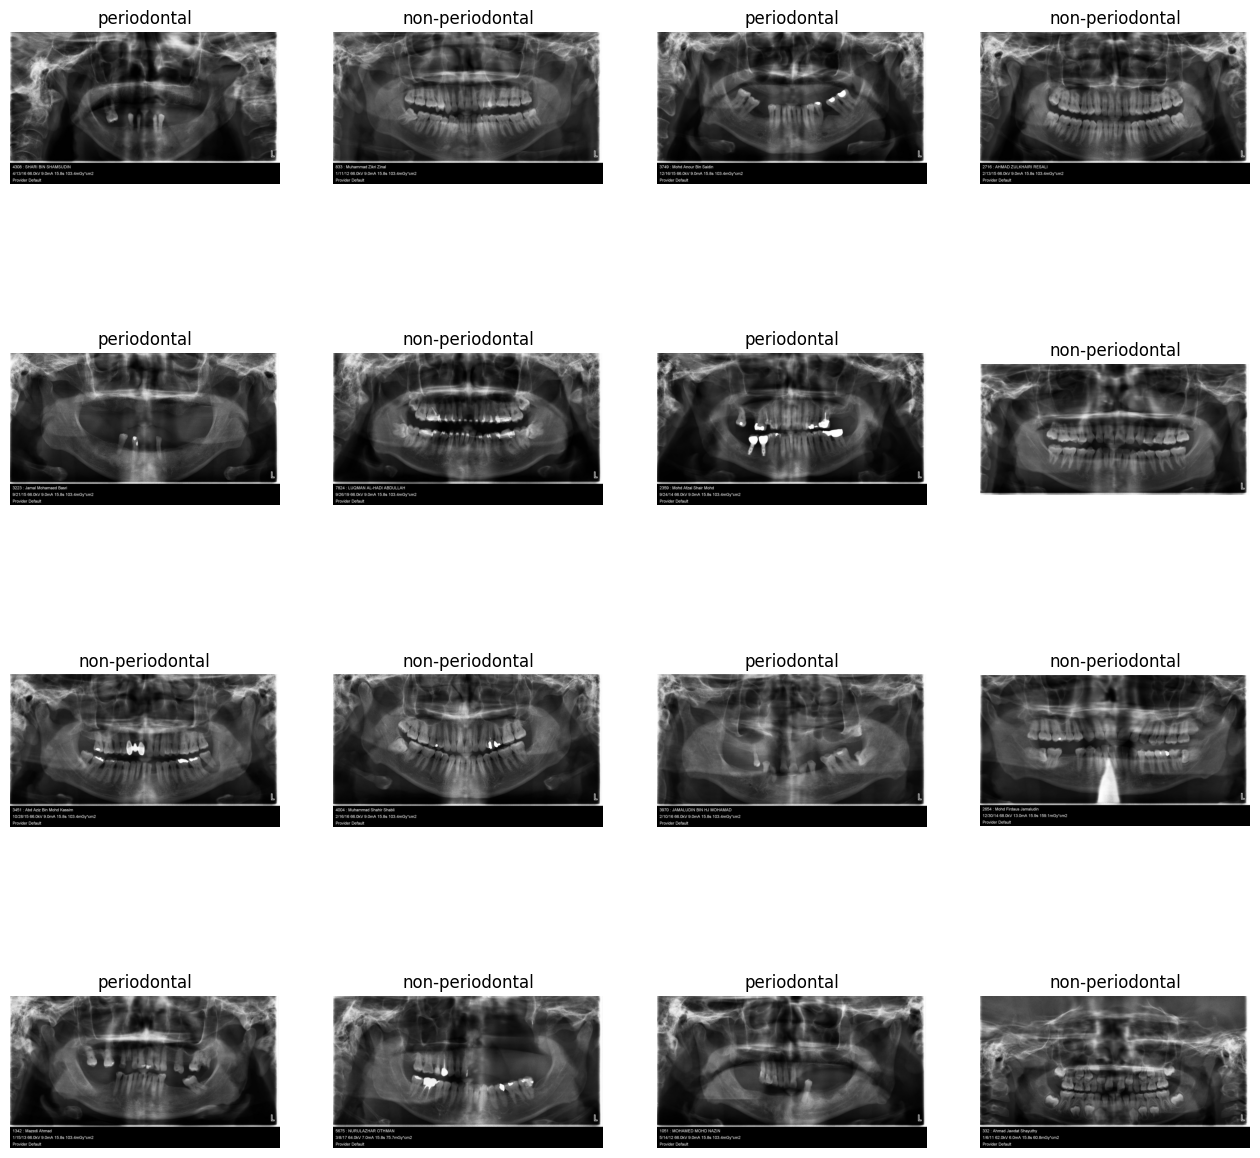

In [ ]:
visualize_samples(train_gen_flow)

In [ ]:
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE_GN,
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(256, activation='selu')(pretrainedModel.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 175, 175, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 175, 175, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
model.fit(
    train_gen_flow,
    validation_data=valid_gen_flow,
    verbose=1,
    epochs=20,
    callbacks = [tf.keras.callbacks.LearningRateScheduler(sched)],
)

Epoch 1/20
6/6 [==============================] - 116s 21s/step - loss: 1.3346 - accuracy: 0.5625 - recall: 0.4865 - val_loss: 1.4682 - val_accuracy: 0.5610 - val_recall: 0.0000e+00 - lr: 9.0484e-04
Epoch 2/20
6/6 [==============================] - 70s 13s/step - loss: 0.7691 - accuracy: 0.6518 - recall: 0.8041 - val_loss: 0.8795 - val_accuracy: 0.5610 - val_recall: 0.2222 - lr: 8.1873e-04
Epoch 3/20
6/6 [==============================] - 87s 13s/step - loss: 0.5417 - accuracy: 0.7440 - recall: 0.5405 - val_loss: 1.0536 - val_accuracy: 0.5610 - val_recall: 0.1389 - lr: 7.4082e-04
Epoch 4/20
6/6 [==============================] - 68s 11s/step - loss: 0.4510 - accuracy: 0.8304 - recall: 0.8514 - val_loss: 1.0572 - val_accuracy: 0.4878 - val_recall: 0.2778 - lr: 6.7032e-04
Epoch 5/20
6/6 [==============================] - 75s 15s/step - loss: 0.3729 - accuracy: 0.8512 - recall: 0.8041 - val_loss: 1.3222 - val_accuracy: 0.5854 - val_recall: 0.1944 - lr: 6.0653e-04
Epoch 6/20
6/6 [=========

In [ ]:
print("Model Evaluation")
score = model.evaluate(valid_gen_flow)

Model Evaluation
2/2 [==============================] - 12s 2s/step - loss: 1.2759 - accuracy: 0.6098 - recall: 0.2500


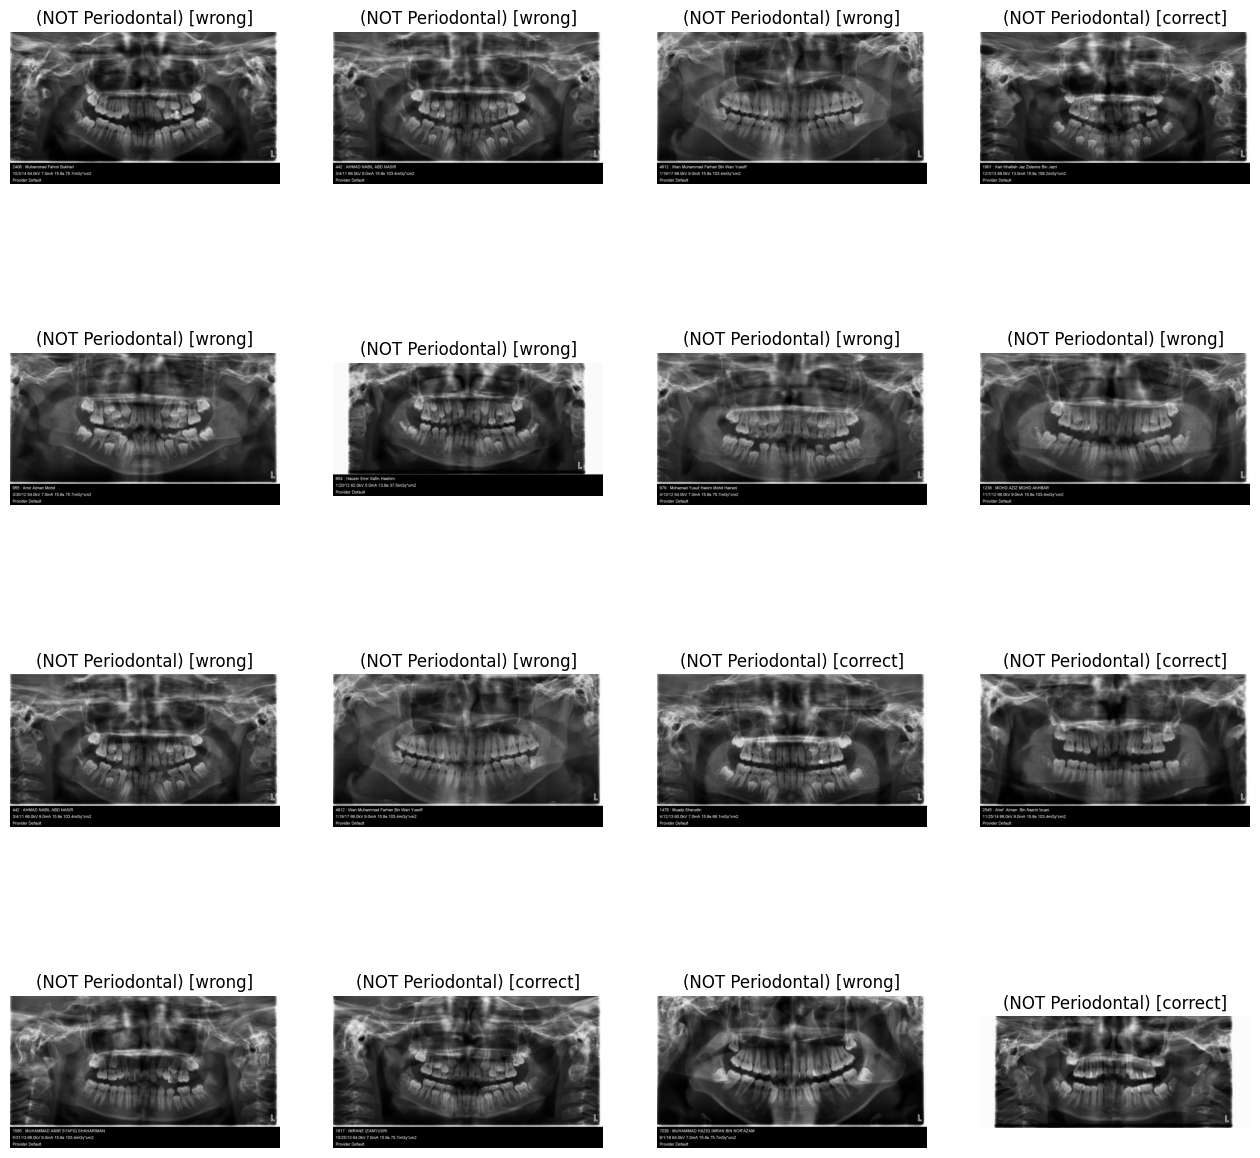

In [ ]:
visualize_classifications(model, valid_gen_flow)

In [ ]:
model.save("/content/drive/MyDrive/PeriodontalClassifier1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
